In [4]:
# coding: utf-8
import numpy as np
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import scipy.integrate as sci_integrate
import time
import sys
from multiprocessing import Process,Pool
import scipy.optimize as sciop
#version 1:
'''parameters'''
def chirp_mass(m1,m2):
    return np.power(m1*m2,0.6)/(np.power(m1+m2,0.2))
def solvem(mc,smr):
    a=mc/np.power(smr,0.6)
    b=smr*np.power(a,2.0)
    m1=(a+np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    m2=(a-np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    return np.array((m1,m2))
def sym_mass_ratio(m1,m2):
    return m1*m2/(np.power(m1+m2,2.0))
'''lisa noise curve in rpsd unit N2A5:laserpower 2w,40cm telescope,armlength 5e6 km'''
def S_gal_N2A5(f):
    if f>=1.0e-5 and f<1.0e-3:
        return np.power(f,-2.3)*np.power(10,-44.62)*20.0/3.0
    if f>=1.0e-3 and f<np.power(10,-2.7):
        return np.power(f,-4.4)*np.power(10,-50.92)*20.0/3.0
    if f>=np.power(10,-2.7) and f<np.power(10,-2.4):
        return np.power(f,-8.8)*np.power(10,-62.8)*20.0/3.0
    if f>=np.power(10,-2.4) and f<=0.01:
        return np.power(f,-20.0)*np.power(10,-89.68)*20.0/3.0
    if f>0.01 or f<1.0e-5:
        return 0
def S_n_lisa(f):
    m1=5.0e9
    m2=sciconsts.c*0.41/m1/2.0
    return 20.0/3.0*(1+np.power(f/m2,2.0))*(4.0*(9.0e-30/np.power(2*sciconsts.pi*f,4.0)*(1+1.0e-4/f))+2.96e-23+2.65e-23)/np.power(m1,2.0)+S_gal_N2A5(f)


# In[34]:

'''vac model(2 mass parameters)'''
def df_dtvac2(f,m_1,m_2):
    m_c=chirp_mass(m_1,m_2)
    M=m_1+m_2
    mu=(m_1+m_2)/m_1/m_2
    a1=743.0/336+11.0*mu/4/M
    a2=sciconsts.G/np.power(sciconsts.c,3.0)
    x=sciconsts.pi*M*f*a2
    return np.power(a2,5.0/3.0)*96.0/5*np.power(sciconsts.pi,8.0/3.0)*np.power(m_c,5.0/3.0)*np.power(f,11.0/3.0)*(1-a1*np.power(x,2.0/3.0)+4*sciconsts.pi*x)
def t_fvac2(f,m_1,m_2,figas):
    return sci_integrate.quad(lambda f:1.0/df_dtvac2(f,m_1,m_2),figas,f,limit=1500)[0]
'''reverse function :t(f) to f(t) to r(t)'''
def f_rvac(r,m):
    m_1=m[0]
    m_2=m[1]
    fi=m[2]
    M=m_1+m_2
    mu=(m_1+m_2)/m_1/m_2
    a=np.sqrt(M)
    b=(-1.5+mu*0.5/M)*sciconsts.G/np.power(sciconsts.c,2.0)
    return np.sqrt(sciconsts.G)/sciconsts.pi*(a/np.power(r,1.5)+b/np.power(r,2.5)*np.power(M,1.5))-fi
def f_rvacstart(fi,m_1,m_2):
    M=m_1+m_2
    return np.power(np.power(sciconsts.G*M,0.5)/(sciconsts.pi*fi),2.0/3.0)

'''my T model(considering gas (SI))'''
def k_1cal(m_1,m_2):
    return 64.0*np.power(sciconsts.G,3.0)*m_1*m_2*(m_1+m_2)/5.0/np.power(sciconsts.c,5.0)
def t_0cal(m_1,m_2,t_gas,a_0):
    return t_gas*0.25*np.log(k_1cal(m_1,m_2)+np.power(a_0,4.0)/t_gas)
def acalgas(t,k_1,t_gas,t_0):
    return np.power((np.exp(4.0*(t_0-t)/t_gas)-k_1)*t_gas,0.25)
def freq_tgas(t,m_1,m_2,t_gas,t_0):
    k_1=k_1cal(m_1,m_2)
    a_ft=acalgas(t,k_1,t_gas,t_0)
    return 1.0/sciconsts.pi*np.sqrt((m_1+m_2)*sciconsts.G)*np.power(a_ft,-1.5)
def phi_tgas(t,m_1,m_2,t_gas,t_0):
    return sci_integrate.quad(lambda x:2*sciconsts.pi*freq_tgas(x,m_1,m_2,t_gas,t_0),0,t)[0]
def hgas(t,m_1,m_2,t_gas,t_0,phi):
    k_1=k_1cal(m_1,m_2)
    return m_1*m_2/acalgas(t,k_1,t_gas,t_0)*np.cos(phi)/1e70


# In[75]:

#consts setting
sivalue=0.125
m_sun=1.9891e30
years=365*24*3600.0
mpc=3.261*sciconsts.light_year
t_scale=4*years*sivalue

In [5]:
sci_integrate.quad(lambda x:1.0/np.sqrt(0.27/x+0.73*np.power(x,2.0)),0,1,limit=2500,epsrel=0.00005)

(0.9926868741224372, 1.836308882730009e-13)

In [3]:
sciconsts.N_A
p=0.04*3*h*h/8/sciconsts.pi/sciconsts.G
mhe=4.002602/sciconsts.N_A*1e-3
mh=1.00794/sciconsts.N_A*1e-3
p*0.25*2/mhe+p*0.75/mh

NameError: name 'h' is not defined

In [6]:
sci_integrate.quad(lambda x:1.0/np.sqrt(1-x*x),0,1,limit=2500,epsrel=0.00005)

(1.5707963267867724, 1.669419537941863e-06)

In [7]:
x=np.power(0.27/0.5,1.0/3)
x

0.81432528497847201

In [8]:
2.0/3/np.sqrt(0.73)

0.78027431464087038

In [9]:
a=np.power(0.27/0.73,1.0/3)
print a
y=a*np.arcsinh(1.5*np.sqrt(0.73))

0.717816826784


In [10]:
1/np.power(np.sinh(1.5*np.sqrt(0.73)*y),2.0/3.0)-x

0.098165203989676986

In [11]:
tmin1=2.0/3*np.arcsinh(np.sqrt(0.73/0.27))/np.sqrt(0.73)
tmin1

0.99268687412243672

In [12]:
1/0.780274/1.5-np.sqrt(0.73)

3.4453189201588685e-07

In [13]:
np.sqrt(0.27/x+0.73*x*x)/x*np.sqrt(0.5)
np.sqrt(0.73)

0.8544003745317531

In [14]:
sci_integrate.quad(lambda x:1.0/np.sqrt(0.27*x+0.73*np.power(x,4.0)),1,np.inf,limit=2500,epsrel=0.00005)

(1.1233903241243217, 7.28813220471486e-13)

In [15]:
1/0.780274 -1.5*np.sqrt(0.73)

5.1679783807934143e-07

In [16]:
sci_integrate.quad(lambda x:1.0/np.sqrt(0.27*x+0.73*np.power(x,4.0)),0.37211,1,limit=2500,epsrel=0.00005)

(1.1233906383328818, 1.2472141523255173e-14)

In [17]:
1/0.37211-1

1.687377388406654

In [18]:
N=1e5
t=np.linspace(0.3721,0.373,N+1)
n=0
i=True
while(i==True and (n<N+1)):
    b=t[n]
    a=sci_integrate.quad(lambda x:1.0/np.sqrt(0.27*x+0.73*np.power(x,4.0)),b,1,limit=2500,epsrel=0.00005)
    n=n+1
    if(a[0]<1.1233903241243217):
        i==False
        print t[n-2],a
        resu=[t[n-2],a]
        break

0.372110098 (1.1233903220717736, 1.2472138012051532e-14)


In [19]:
1/0.37211-1

1.687377388406654

In [20]:
h=70*1000/sciconsts.parsec/1e6
h
ha=h*np.sqrt(0.73)
ha

1.9382461271898172e-18

In [21]:
years*h

7.154085097464623e-11

In [22]:
0.780274*np.arcsinh(1.64429*np.power(1,1.5))
tmax=1e11*years*ha
tmin=tmin1/h*ha
tmin,tmax

(0.84815203704296516, 6.1124529867058079)

In [23]:
def f(y,t):
    return (1+y)/np.tanh(1.5*t)-1.0/np.tanh(1.5*t)*np.sqrt(0.73+0.27*np.power(1+y,3.0))

In [24]:
import scipy.integrate

In [25]:
eq=np.arcsinh(1)*2/3/ha*h
np.sinh(eq/0.780274)/1.64429
np.power(0.77723755486060064,2.0/3)

0.84534862623333817

In [26]:
a=np.linspace(tmin,tmax,1e6)
c=scipy.integrate.odeint(f,1.687377388406654,a)

In [34]:
k=np.power(0.27/0.73,1.0/3)*np.power(np.sinh(1.5*a),2.0/3)

In [36]:
q=k/(1+s)

In [39]:
tau2=2.0/3/np.sqrt(0.73)/h*np.arcsinh(np.sqrt(0.73/0.23)*np.power(q,1.5))

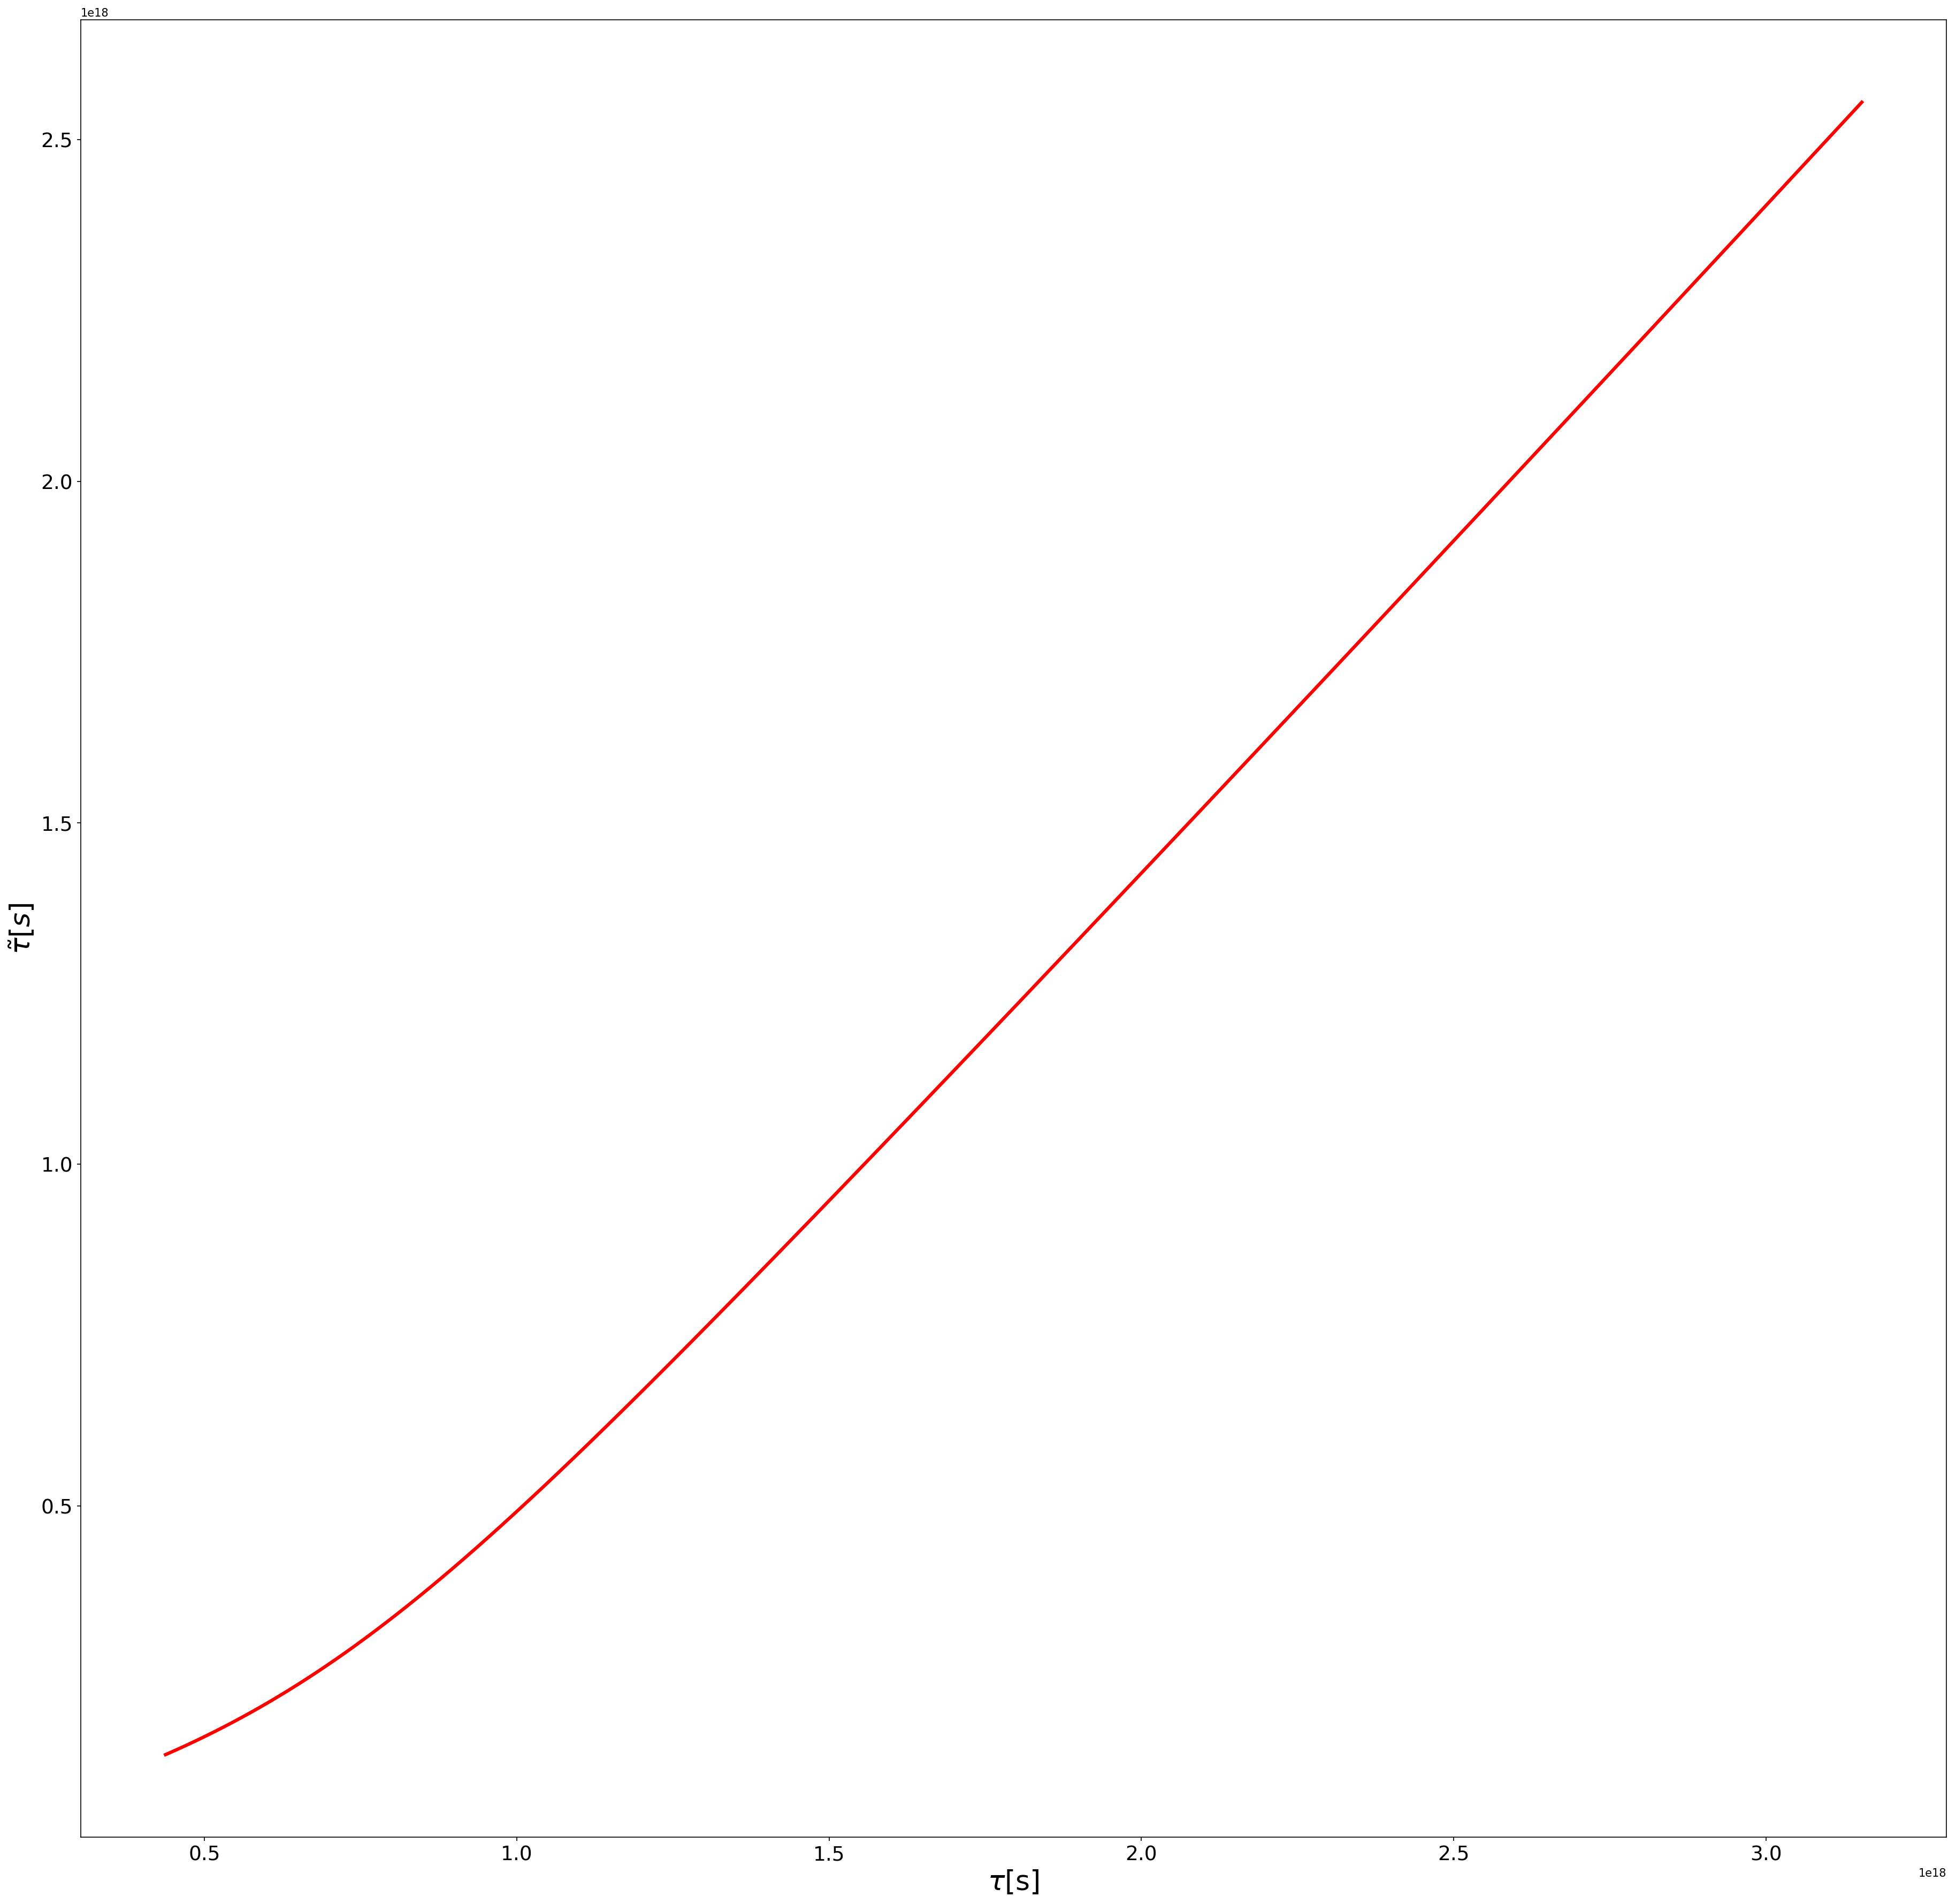

In [49]:

fig1=plt.figure(figsize=(30,30),dpi=150)
plt.ylabel(r'$\tilde{\tau}[s]$',fontsize=25)
plt.xlabel(r'$\tau$[s]',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(a/ha,tau2,color='red',linewidth=3.0)
plt.show()

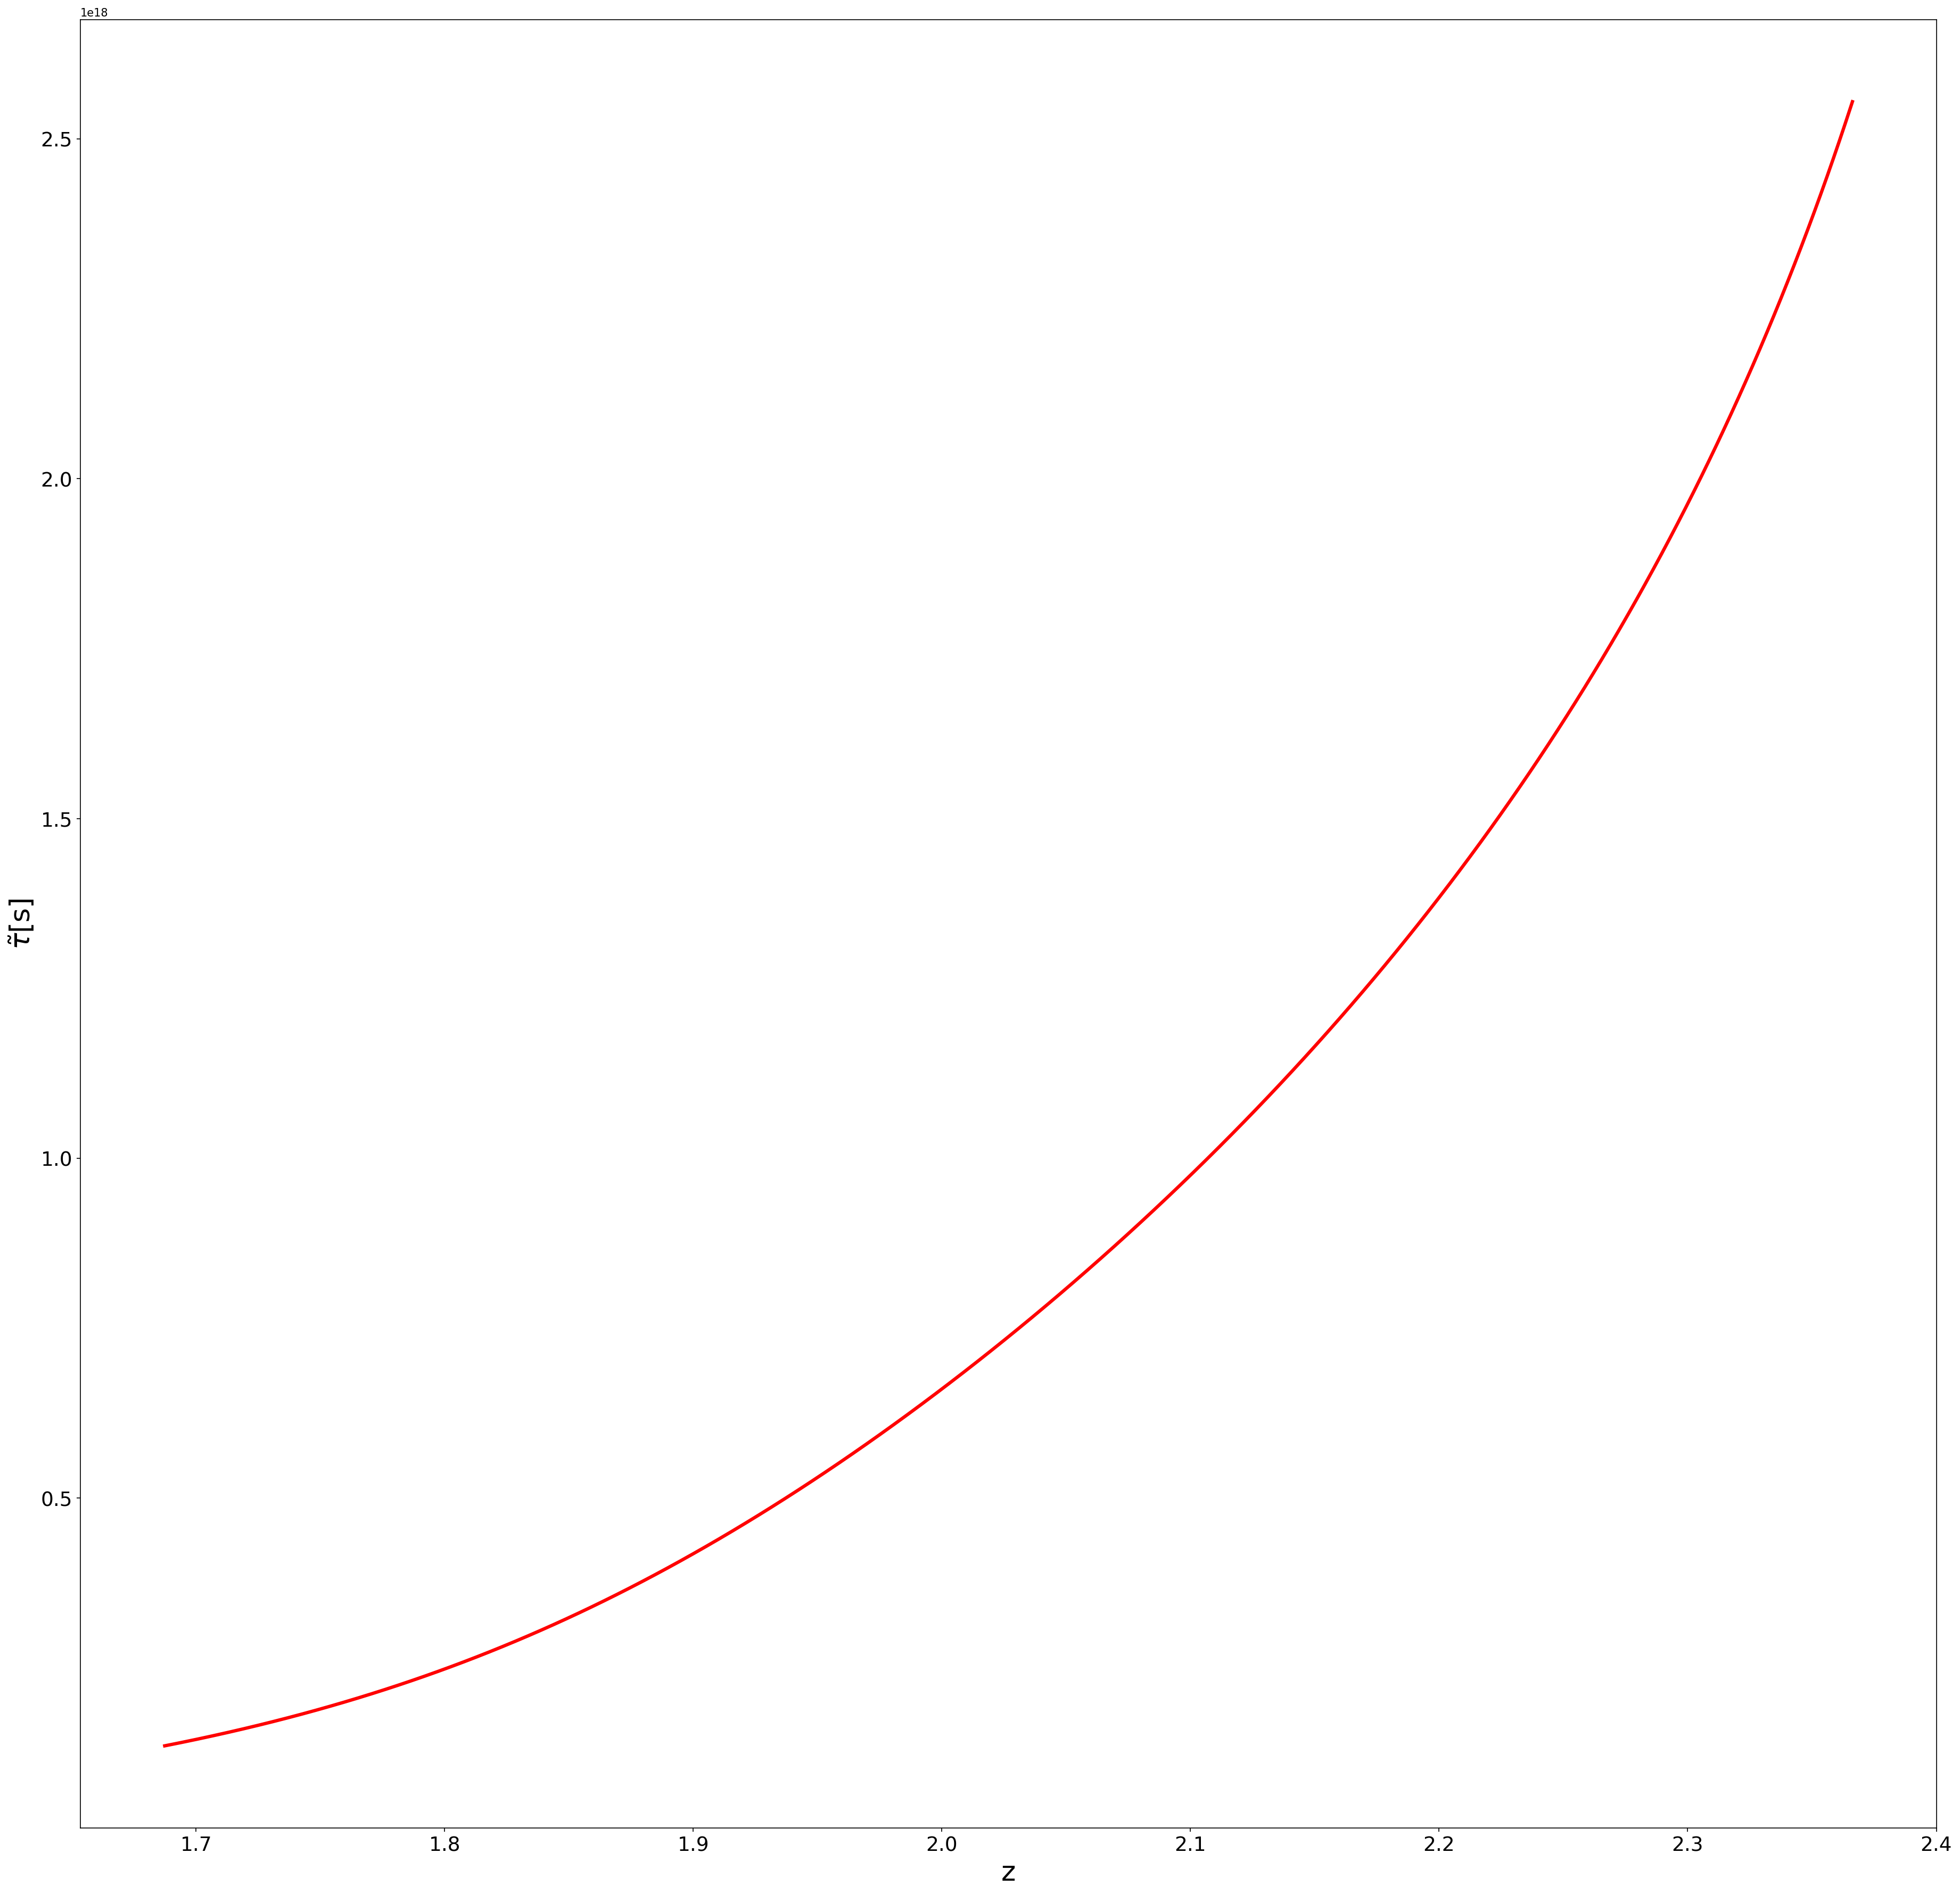

In [48]:

fig1=plt.figure(figsize=(30,30),dpi=150)
plt.ylabel(r'$\tilde{\tau}$[s]',fontsize=25)
plt.xlabel(r'z',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(c,tau2,color='red',linewidth=3.0)
plt.show()

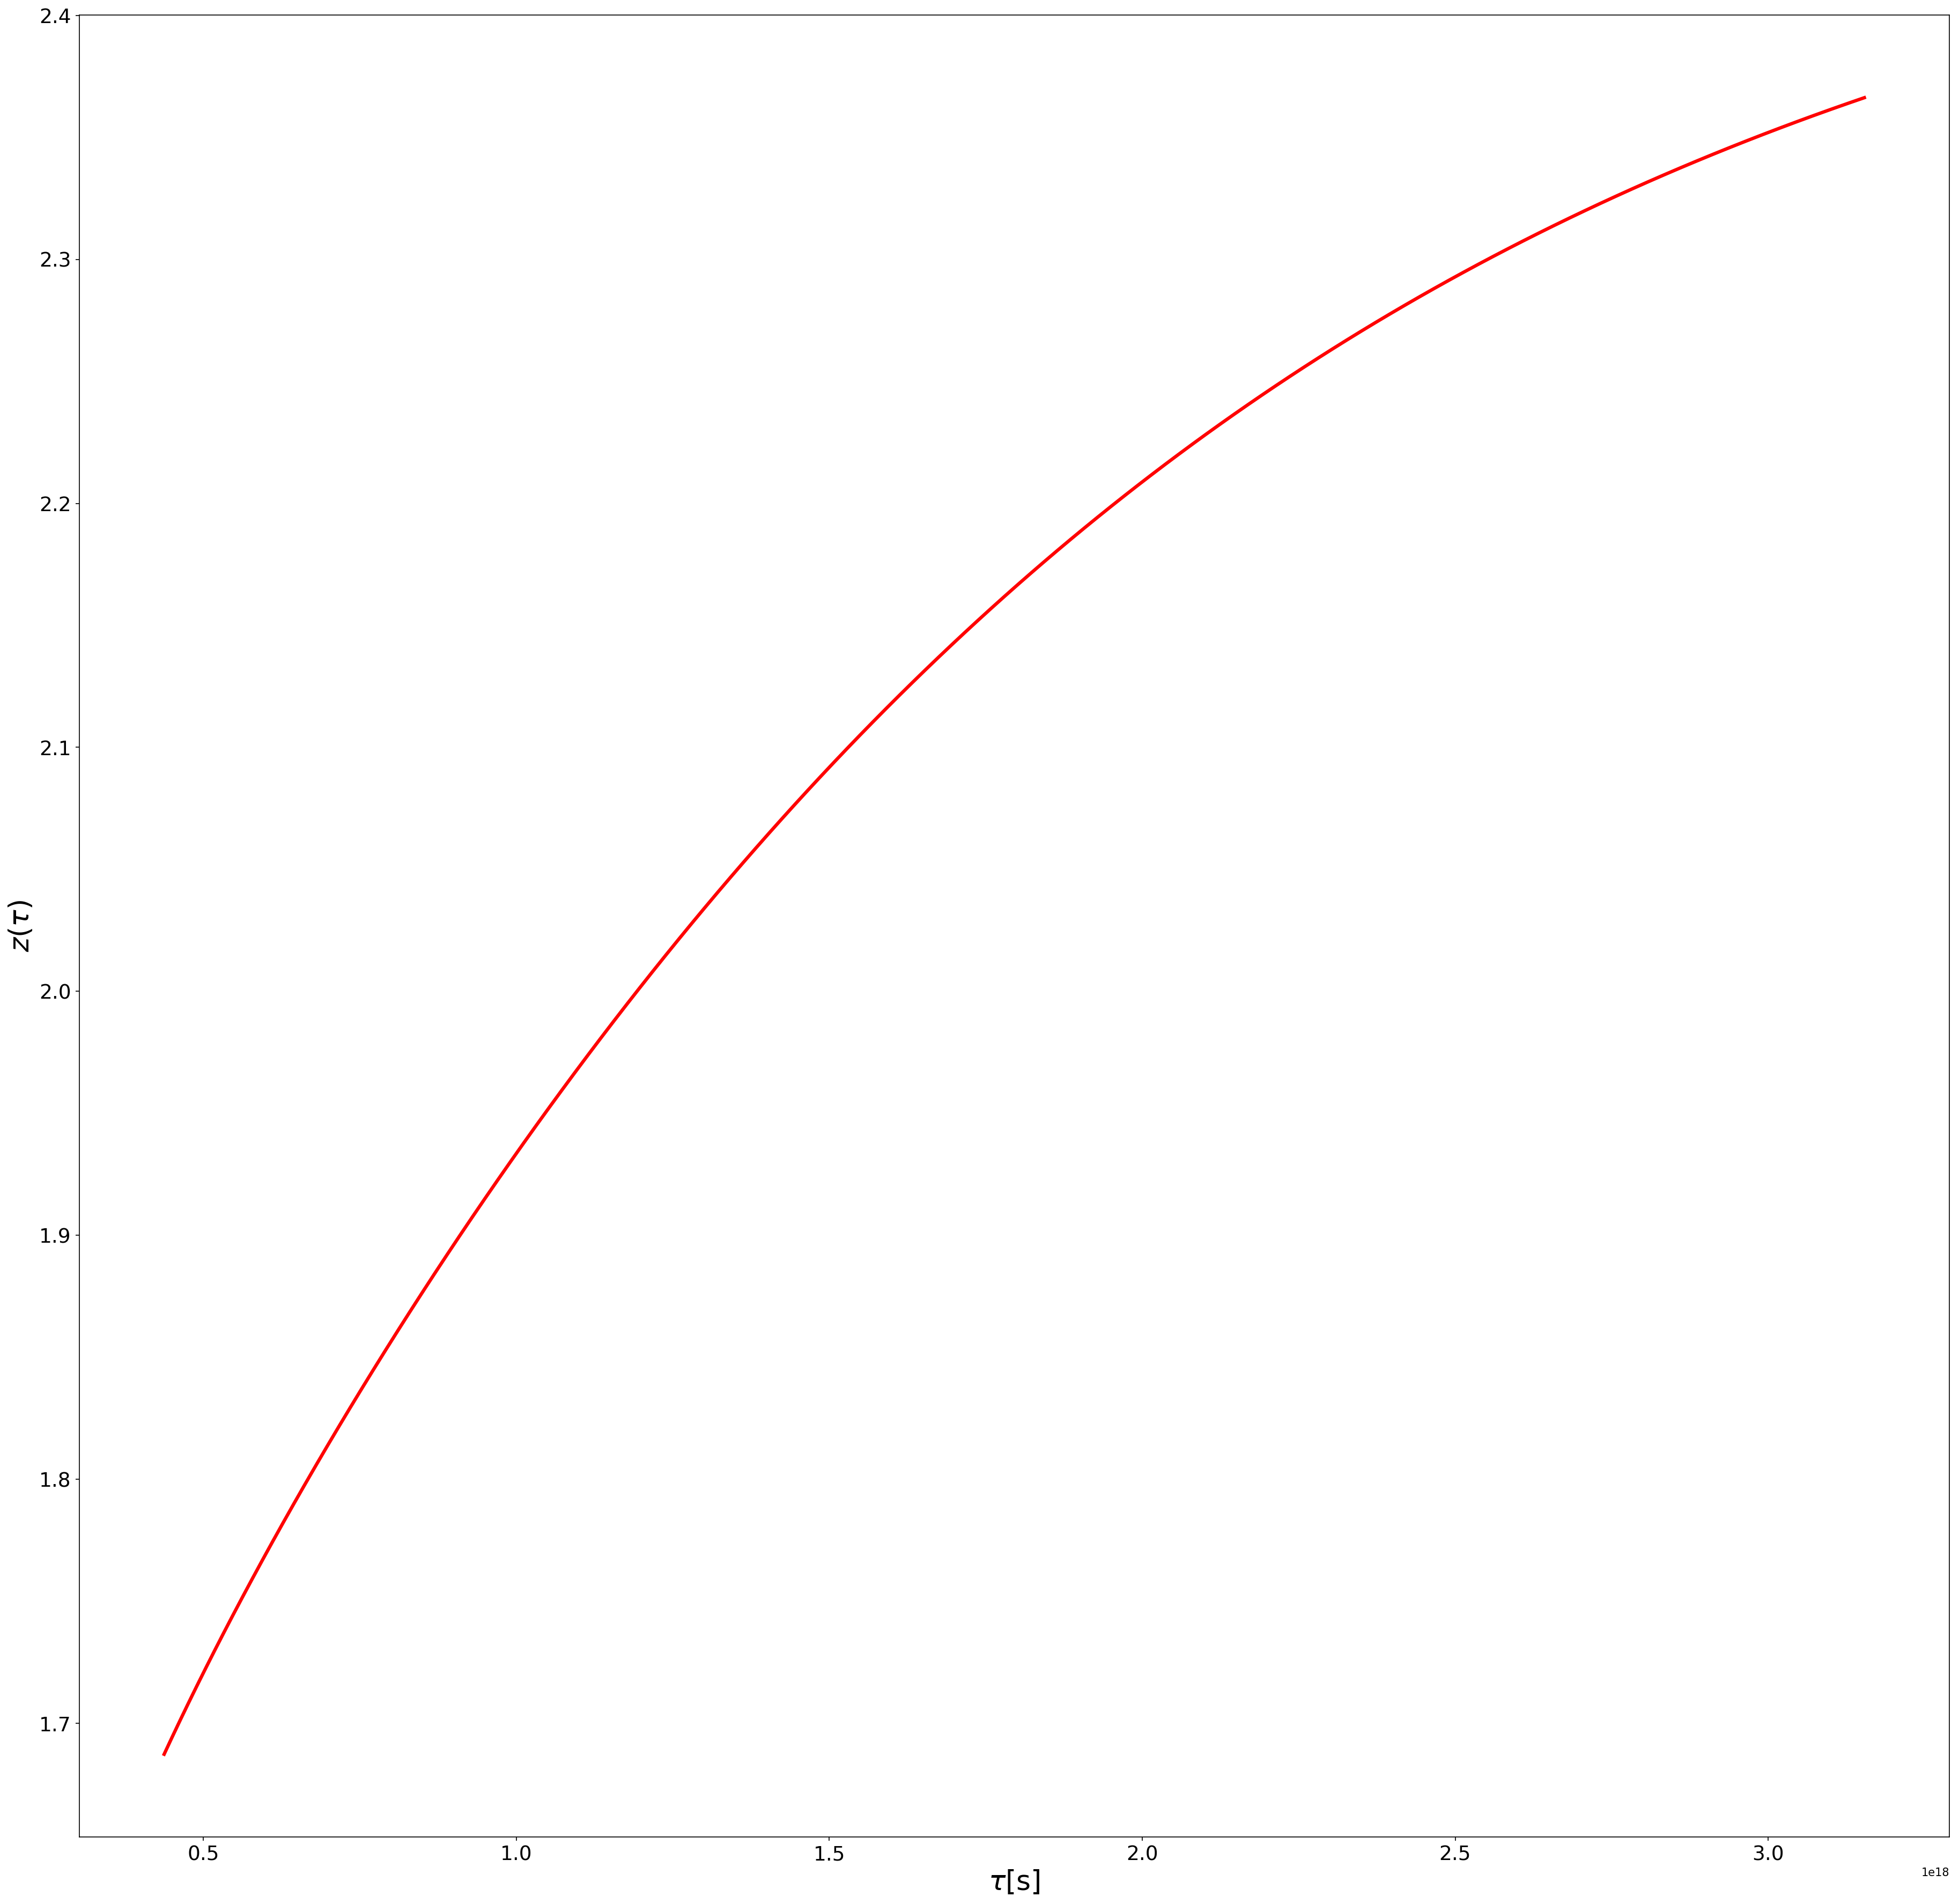

In [50]:
import matplotlib.pyplot as plt
import matplotlib  
import matplotlib.cm as cm   
from matplotlib.ticker import MultipleLocator  
from mpl_toolkits.mplot3d import Axes3D
from scipy.misc import derivative
fig1=plt.figure(figsize=(30,30),dpi=150)
plt.ylabel(r'$z(\tau)$',fontsize=25)
plt.xlabel(r'$\tau$[s]',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(a/ha,c,color='red',linewidth=3.0)
plt.show()

In [32]:
b=float('nan')
b

nan

In [73]:
import matplotlib.pyplot as plt
import matplotlib  
import matplotlib.cm as cm   
from matplotlib.ticker import MultipleLocator  
from mpl_toolkits.mplot3d import Axes3D
from scipy.misc import derivative
fig1=plt.figure(figsize=(30,30),dpi=150)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(a,c,color='red')
plt.xscale('log')
plt.show()

OverflowError: In draw_path: Exceeded cell block limit

In [6]:
1.039891183573976/0.31046202297002812

3.349495611817123

In [35]:
np.power(np.power(np.sinh(h*eq/0.780274)/1.64429,2.0/3.0),3.0)

0.6040982166856852

In [45]:
0.9927*np.sqrt(0.5)*1.5
b=np.sinh(0.9927*np.sqrt(0.5)*1.5)
np.power(b,2)

1.5839250978288011

In [46]:
0.5/0.27

1.8518518518518516

In [53]:
a=1/np.power(0.27/0.5,1.0/3)
np.arcsinh(np.power(a,3.0/2.0))*2/3/np.sqrt(0.5)

1.0512327427921868

## # In[37]:

#gas cal
m_cg=chirp_mass(10*m_sun,10*m_sun)
m_1g=solvem(m_cg,0.24221453287197228)[0]
m_2g=solvem(m_cg,0.24221453287197228)[1]
'''mass ratio=0.7 smr=0.24221453287197228'''
k_1g=k_1cal(m_1g,m_2g)
t_gas=1000.0*years
a_0=3.0e8
t_0g=t_0cal(m_1g,m_2g,t_gas,a_0)

# In[38]:

#(t_scale*0.01*4,N/0.01/t_scale,t_scale) 
figas=freq_tgas(0,m_1g,m_2g,t_gas,t_0g)
ffgas=freq_tgas(t_scale,m_1g,m_2g,t_gas,t_0g)
Ng=int(10000000*sivalue)
t=np.linspace(0,t_scale,num=Ng)
#tdomain interp1d
n1=10000
tphi=np.linspace(0,t_scale,n1)
i=0
workphi=np.zeros(n1)
while i<n1:
    workphi[i]=phi_tgas(tphi[i],m_1g,m_2g,t_gas,t_0g)
    i=i+1
phimo=sci_interpolate.interp1d(tphi,workphi)
#tdomain point cal
Tg=t_scale/Ng
hfgas=hgas(t,m_1g,m_2g,t_gas,t_0g,phimo(t))
#fft
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)6 
hfgas1=fft.fft(hfgas)
hfgas_abs=abs(hfgas1)
hfgas_angle=np.arctan(hfgas1.imag/hfgas1.real)[0:Ng//2]
hfgas2=2.0/Ng*hfgas_abs[0:Ng//2]
hs=sci_interpolate.interp1d(xs,hfgas2)
anglegas=sci_interpolate.interp1d(xs,hfgas_angle)


# In[76]:

A=sci_integrate.quad(lambda x:4*np.power(hs(x),2.0)/S_n_lisa(x),figas,ffgas,limit=1500,epsabs=0.0005)
Aval=np.sqrt(A[0])
Aerr=0.5/Aval*A[1]
Aval,Aerr


# In[78]:

# sciode
def df_dtode(f,t,m_1,m_2):
    m_c=chirp_mass(m_1,m_2)
    M=m_1+m_2
    mu=(m_1+m_2)/m_1/m_2
    a1=743.0/336+11.0*mu/4/M
    a2=sciconsts.G/np.power(sciconsts.c,3.0)
    x=sciconsts.pi*M*f*a2
    result=np.power(a2,5.0/3.0)*96.0/5*np.power(sciconsts.pi,8.0/3.0)*np.power(m_c,5.0/3.0)*np.power(f,11.0/3.0)*(1-a1*np.power(x,2.0/3.0)+4*sciconsts.pi*x)
    return result


# In[102]:

def find_max2(m):
    mcv=m[0]*m_sun
    smrv=m[1]
    figas=m[2]
    ffgas=m[3]
    sv=solvem(mcv,smrv)
    m1v=sv[0]
    m2v=sv[1]
    n2=10000
    ts=np.linspace(0,t_scale,n2)
    yf=sci_integrate.odeint(df_dtode,figas,ts,args=(m1v,m2v))
    ftv=sci_interpolate.interp1d(ts,yf.T[0])
    fr=ftv(ts)
    phiv1=np.zeros(n2)
    i=0
    while i<n2:
        phiv1[i]=sci_integrate.quad(lambda x:2*sciconsts.pi*ftv(x),0,ts[i])[0]
        i=i+1
    phiv=sci_interpolate.interp1d(ts,phiv1)
    
    rs=np.zeros(n2)
    rs[0]=sciop.fsolve(f_rvac,f_rvacstart(figas,m1v,m2v),args=[m1v,m2v,figas])
    
    for i in range(1,n2,1):
        rs[i]=sciop.fsolve(f_rvac,rs[i-1],args=[m1v,m2v,fr[i]])
    
    rv=sci_interpolate.interp1d(ts,rs)
    
    t_scalev=ts[n2-1]
    t=np.linspace(0,t_scalev,num=Ng)
    hv=m1v*m2v/rv(t)*np.cos(phiv(t))/1e70
    xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
    hfvac1=fft.fft(hv)
    hfvac_abs=abs(hfvac1)
    hfvac_angle=np.arctan(hfvac1.imag/hfvac1.real)[0:Ng//2]
    hfvac2=2.0/Ng*hfvac_abs[0:Ng//2]
    hvacr=sci_interpolate.interp1d(xs,hfvac2)
    anglevac=sci_interpolate.interp1d(xs,hfvac_angle)
    B=sci_integrate.quad(lambda x:4*np.power(hvacr(x),2.0)/S_n_lisa(x),figas,fr[n2-1],limit=1500,epsabs=0.005)
    Bval=np.sqrt(B[0])
    Berr=0.5/Bval*B[1]
    #phi max finding
    phinum=100
    phics=np.linspace(0,2*sciconsts.pi,phinum)
    ffmax=0
    errmax=0
    phimaxpos=0
    for phic in phics:
        AB=sci_integrate.quad(lambda x:4*hvacr(x)*hs(x)/S_n_lisa(x)*np.cos(anglegas(x)-anglevac(x)+phic),figas,fr[n2-1],limit=2500,epsrel=0.005)
        ff=abs(AB[0]/Aval/Bval)
        err=abs(1/Aval/Bval*AB[1])+abs(AB[0]/Aval/Aval/Bval*Aerr)+abs(AB[0]/Aval/Bval/Bval*Berr)
        #err1=abs(1*AB[1]/AB[0])+abs(1.0/Aval*Aerr)+abs(1.0/Bval*Berr)
        if ff>ffmax:
            ffmax=ff
            errmax=err
            phimaxpos=phic
    print ffmax,errmax,m[0],m[1],phimaxpos
    sys.stdout.flush()
    return ffmax,errmax,m[0],m[1],phimaxpos


# In[ ]:

a=time.time()
pool = Pool(20)
results = []
tasknum=int(sys.argv[1])
#tasknum from 0-9 for 10nodes，20cpus in every node（pkuhpc system cn-short）
mci=float(sys.argv[2])
mcf=float(sys.argv[3])
corenum=int(sys.argv[4])
n3=600
ns=100
nc=n3/ns
del_mc=(mcf-mci)/nc/corenum
mcii=mci+nc*tasknum*del_mc
mcff=mcii+del_mc*nc
m_cs=np.linspace(mcii,mcff,int(nc))
smrs=np.linspace(0.24,0.25,int(ns))
m_cs2=np.zeros(int(n3))
smrs2=np.zeros(int(n3))
for i in range(0,nc):
    for j in range(0,ns):
        m_cs2[i*ns+j]=m_cs[i]
        smrs2[i*ns+j]=smrs[j]
f1=np.zeros(int(n3))+figas
f2=np.zeros(int(n3))+ffgas
para=[m_cs2,smrs2,f1,f2]
para1=np.transpose(para)
results = pool.map(find_max2, para1)
b=time.time()
pool.close()
pool.join()
b=time.time()
print 'processes done, :',b-a,'seconds used'
sys.stdout.flush()
fname='f %s-%s'%(mcii,mcff)
np.save(fname,results)


In [51]:
print scipy.version.version

0.18.1


In [53]:
1.1234/h/sciconsts.parsec

16.048571428571428

In [55]:
np.power(0.27/0.73,1.0/3)

0.7178168267839119